# Прогнозирование оттока по данным [Rekko Challenge 2019](https://boosters.pro/championship/rekko_challenge/overview)

In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp
import matplotlib.pyplot as plt

from pprint import pprint

### Загрузка данных

In [2]:
DATA_PATH = './data/'

In [3]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

CPU times: user 5.63 s, sys: 320 ms, total: 5.95 s
Wall time: 6.08 s


In [4]:
transactions.head()

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


 - `element_uid` — идентификатор элемента
 - `user_uid` — идентификатор пользователя
 - `consumption_mode` — тип потребления (`P` — покупка, `R` — аренда, `S` — просмотр по подписке)
 - `ts` — время совершения транзакции или начала просмотра в случае просмотра по подписке
 - `watched_time` — число просмотренных по транзакции секунд
 - `device_type` — анонимизированный тип устройства, с которого была совершена транзакция или начат просмотр
 - `device_manufacturer` — анонимизированный производитель устройства, с которого была совершена транзакция или начат просмотр

In [5]:
print("В transactions имеем %d записей, %d пользователей и %d продуктов." % (transactions.shape[0], 
                                                                            transactions.user_uid.nunique(), 
                                                                            transactions.element_uid.nunique()))


В transactions имеем 9643012 записей, 499663 пользователей и 8296 продуктов.


### Кого считать ушедшим пользователем
Для определения ушел пользователь или нет, подсчитаем сколько времени прошло между транзакциями каждого пользователя. На основе этих данных выберем такое время без транзакций, после которого считаем, что пользователь ушел.

In [6]:
df = transactions.copy()

In [7]:
gaps = df[['user_uid', 'ts']].drop_duplicates() \
                             .groupby('user_uid')['ts'] \
                             .apply(list).apply(np.diff).values

gaps = np.concatenate(gaps, axis=0)
gaps = np.abs(gaps)

day_gaps = gaps/(60*60*24)

Для наглядности построим гистограмму:

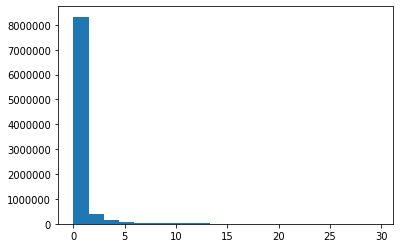

In [8]:
plt.hist(day_gaps, bins=20);

На гистограмме видим, что интервал между транзакциями больше 14 дней практически не встречается.

In [9]:
np.sum(day_gaps > 14) / day_gaps.shape[0]

0.004676589416783513

Таким образом, выбрав период оттока в 14 дней, мы ошибемся не более, чем в 0.5% случаев.

### Вычисление ушедший пользователей
Сначала уберем из рассмотрения тех, кто впервые совершил транзакцию в последние две недели, т.к. для них невозможно определить ушли они или нет.

In [10]:
max_started_ts = df.ts.max() - 14*60*60*24

df = df.merge(df.groupby('user_uid', as_index=False)[['ts']].min() \
              .rename({'ts': 'min_ts'}, axis=1), how='outer', on='user_uid')

df = df[df.min_ts < max_started_ts]

Будем считать ушедшим того, кто в последние две недели не совершил ни одной транзакции.

In [11]:
df = df.merge(df.groupby('user_uid', as_index=False)[['ts']].max() \
              .rename({'ts': 'max_ts'}, axis=1), how='outer', on='user_uid')

df['churn'] = df.max_ts < max_started_ts
df = df.drop(['min_ts', 'max_ts'], axis=1)

In [12]:
df.head(10)

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,churn
0,481,593316,S,4.430518e+07,2989,0,11,False
1,7681,593316,S,4.426540e+07,17997,0,50,False
2,5746,593316,P,4.426267e+07,115,0,50,False
3,230,593316,P,4.426183e+07,5552,0,11,False
4,3250,593316,S,4.417977e+07,2992,0,50,False
5,3213,593316,S,4.417702e+07,30819,0,11,False
6,8849,593316,S,4.415977e+07,5342,0,50,False
7,9520,593316,S,4.415975e+07,6,0,50,False
8,3960,593316,S,4.415968e+07,0,0,50,False
9,2657,593316,S,4.415949e+07,80,0,50,False


### Первичный анализ ушедших пользователей
Для начала посчитаем соотношение ушедших и оставшихся пользователей:

In [13]:
df.groupby('user_uid')['churn'].first().value_counts(normalize=True)

False    0.678751
True     0.321249
Name: churn, dtype: float64

Посмотрим на количество покупок, аренд и просмотров по подписке у ушедших и оставшихся пользователей:

In [14]:
mean_consumptions_churned = pd.DataFrame(df[df['churn']].groupby('user_uid')['consumption_mode'].value_counts())

mean_consumptions_churned = mean_consumptions_churned.groupby(level=1).mean() \
                                                     .rename({'consumption_mode': 'mean_churned'}, axis=1)

mean_consumptions_unchurned = pd.DataFrame(df[df['churn'] == False].groupby('user_uid')['consumption_mode'].value_counts())

mean_consumptions_unchurned = mean_consumptions_unchurned.groupby(level=1).mean() \
                                                         .rename({'consumption_mode': 'mean_unchurned'}, axis=1)

mean_consumptions = mean_consumptions_churned.merge(mean_consumptions_unchurned, on='consumption_mode')

In [15]:
mean_consumptions

,mean_churned,mean_unchurned
consumption_mode,,
P,1.778279,5.763950
R,1.989368,4.192542
S,8.701727,25.729539


Таким образом, можно сделать некоторые выводы о стоимости удержания пользователя: 
1) если бы пользователь не ушел, то он в этом месяце в среднем купил бы еще 3,98 фильма и арендовал — 2,2 (в предположении, что эти неушедшие пользователи будут вести себя, как лояльные, что не всегда правда)
2) если бы пользователь не ушел, то он покупал бы 1.78 ежемесячно в среднем и арендовал — 1.99.